# Ruble Volatility Project — Part 3: Time Series Modeling

This notebook continues the Ruble Volatility Project...

In this notebook ...

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")

try:
    from stargazer.stargazer import Stargazer
except ImportError:
    Stargazer = None

try:
    import shap
except ImportError:
    shap = None

### I. Loading data

In [6]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/Full_Ruble_Monthly_Data.csv")
data = data.sort_values('date').reset_index(drop=True)
data.head()

,date,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB,RUB_diff1,RUB_diff12
0,1992-08-31,170.400000,1992.0,8.0,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,4.335646,1.0,pre,0.170400,0.007250,0.039323
1,1992-09-30,220.488889,1992.0,9.0,3098.802734,20.18,1490.418425,1.161000e+09,1490.418425,2.546404,1.0,pre,0.220489,0.005444,0.060633
2,1992-10-31,353.777778,1992.0,10.0,3098.802734,19.13,1490.418425,1.161000e+09,1490.418425,5.348118,1.0,pre,0.353778,0.016000,0.156322
3,1992-11-30,426.250000,1992.0,11.0,3098.802734,19.25,1490.418425,1.161000e+09,1490.418425,1.491099,1.0,pre,0.426250,0.006125,0.126250
4,1992-12-31,414.555556,1992.0,12.0,3098.802734,17.85,1490.418425,1.161000e+09,1490.418425,-0.785487,1.0,pre,0.414556,-0.003611,0.015444


In [7]:
def create_lag_features(df, target_col, lags=[1, 3, 6]):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

# Apply to RUB exchange rate
data = create_lag_features(data, target_col='RUB', lags=[1, 3, 6])

# Apply to key macro variables if needed
macro_cols = ['GDP_per_capita', 'FD_investment', 'Inflation', 'Brent_price']
for col in macro_cols:
    data = create_lag_features(data, target_col=col, lags=[1, 3])

In [8]:
def add_rolling_stats(df, col, windows=[3, 6]):
    for window in windows:
        df[f'{col}_rollmean{window}'] = df[col].rolling(window).mean()
        df[f'{col}_rollstd{window}'] = df[col].rolling(window).std()
    return df

# Apply to RUB only to avoid too many features
data = add_rolling_stats(data, col='RUB', windows=[3, 6])

In [9]:
# Feature engineering based on available columns in data

# Check and create 'post_denom' if possible
if 'denomination' in data.columns:
    data['post_denom'] = (data['denomination'] == 'post').astype(int)
elif 'post_denom' in data.columns:
    data['post_denom'] = data['post_denom'].astype(int)

# Check and create 'post_soviet_disruption' if possible
if 'sov_disrupt' in data.columns:
    data['post_soviet_disruption'] = (data['sov_disrupt'] == 1).astype(int)
elif 'post_soviet_disruption' in data.columns:
    data['post_soviet_disruption'] = data['post_soviet_disruption'].astype(int)

# Add month (seasonality capture) if 'date' is datetime or string
if 'date' in data.columns:
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month

In [10]:
data

,date,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,...,Inflation_lag1,Inflation_lag3,Brent_price_lag1,Brent_price_lag3,RUB_rollmean3,RUB_rollstd3,RUB_rollmean6,RUB_rollstd6,post_denom,post_soviet_disruption
0,1992-08-31,170.400000,1992.0,8,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,4.335646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,1992-09-30,220.488889,1992.0,9,3098.802734,20.18,1490.418425,1.161000e+09,1490.418425,2.546404,...,1490.418425,NaN,19.65,NaN,NaN,NaN,NaN,NaN,0,1
2,1992-10-31,353.777778,1992.0,10,3098.802734,19.13,1490.418425,1.161000e+09,1490.418425,5.348118,...,1490.418425,NaN,20.18,NaN,0.248222,0.094782,NaN,NaN,0,1
3,1992-11-30,426.250000,1992.0,11,3098.802734,19.25,1490.418425,1.161000e+09,1490.418425,1.491099,...,1490.418425,1490.418425,19.13,19.65,0.333506,0.104368,NaN,NaN,0,1
4,1992-12-31,414.555556,1992.0,12,3098.802734,17.85,1490.418425,1.161000e+09,1490.418425,-0.785487,...,1490.418425,1490.418425,19.25,20.18,0.398194,0.038908,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2025-04-30,83.243645,2025.0,4,14260.000000,63.37,8.200000,3.300000e+09,8.140000,-0.213785,...,8.140000,8.140000,77.23,77.11,87.245267,4.682162,94.227745,8.222254,1,0
393,2025-05-31,80.237650,2025.0,5,14260.000000,64.32,8.200000,3.300000e+09,8.140000,-0.178412,...,8.140000,8.140000,63.37,74.76,83.192965,2.930304,90.819445,9.190465,1,0
394,2025-06-30,78.677635,2025.0,6,14260.000000,68.15,8.200000,3.300000e+09,8.140000,-0.004909,...,8.140000,8.140000,64.32,77.23,80.719643,2.320851,86.889110,8.320857,1,0
395,2025-07-31,78.850139,2025.0,7,14260.000000,73.43,8.200000,3.300000e+09,8.140000,0.101659,...,8.140000,8.140000,68.15,63.37,79.255141,0.855238,83.250204,5.311710,1,0


In [11]:
# Drop rows with NaNs from lag/rolling calculations
data_model = data.dropna().copy()

In [12]:
# Set target and features
target_col = 'RUB'
feature_cols = [col for col in data_model.columns if col not in ['date', 'RUB']]

# Train/test split: last 20% for testing
split_index = int(len(data_model) * 0.8)
train = data_model.iloc[:split_index]
test = data_model.iloc[split_index:]

X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]

In [13]:
# Naive forecast: use RUB_lag1 as prediction
y_pred_naive = test['RUB_lag1']

# Baseline RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_naive))
print(f"Baseline RMSE (Lag-1): {baseline_rmse:.4f}")

Baseline RMSE (Lag-1): 5.3039


In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Remove object/categorical columns not supported by XGBoost unless handled
X_train_fixed = X_train.select_dtypes(include=[np.number])
X_test_fixed = X_test.select_dtypes(include=[np.number])

# Initialize model
xgb = XGBRegressor(random_state=42, n_estimators=100)

# Train
xgb.fit(X_train_fixed, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test_fixed)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

XGBoost RMSE: 9.0677


In [15]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Only use numeric columns for XGBoost (exclude object/categorical)
X_all_fixed = data_model[feature_cols].select_dtypes(include=[np.number])

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    xgb,
    X_all_fixed,
    data_model[target_col],
    scoring='neg_root_mean_squared_error',
    cv=tscv
)

print(f"CV RMSE: {-scores.mean():.4f} ± {scores.std():.4f}")

CV RMSE: 11.2174 ± 9.5975


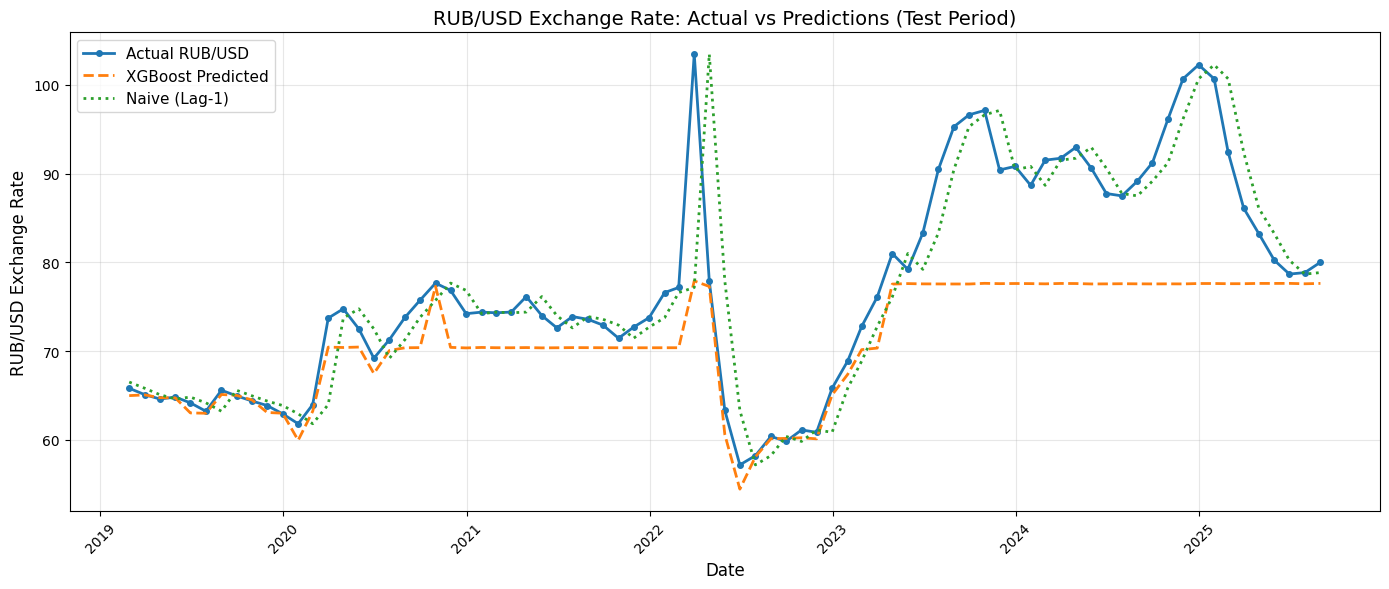


Model Performance Summary:
Baseline RMSE (Lag-1): 5.3039
XGBoost RMSE: 9.0677
Improvement over baseline: -71.0%

Test period: 2019-02 to 2025-08
Number of test observations: 79


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test['date'], y_test, label='Actual', marker='o')
plt.plot(test['date'], y_pred_xgb, label='Predicted', linestyle='--')
plt.title('XGBoost Forecast vs Actual')
plt.ylabel('RUB/USD')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

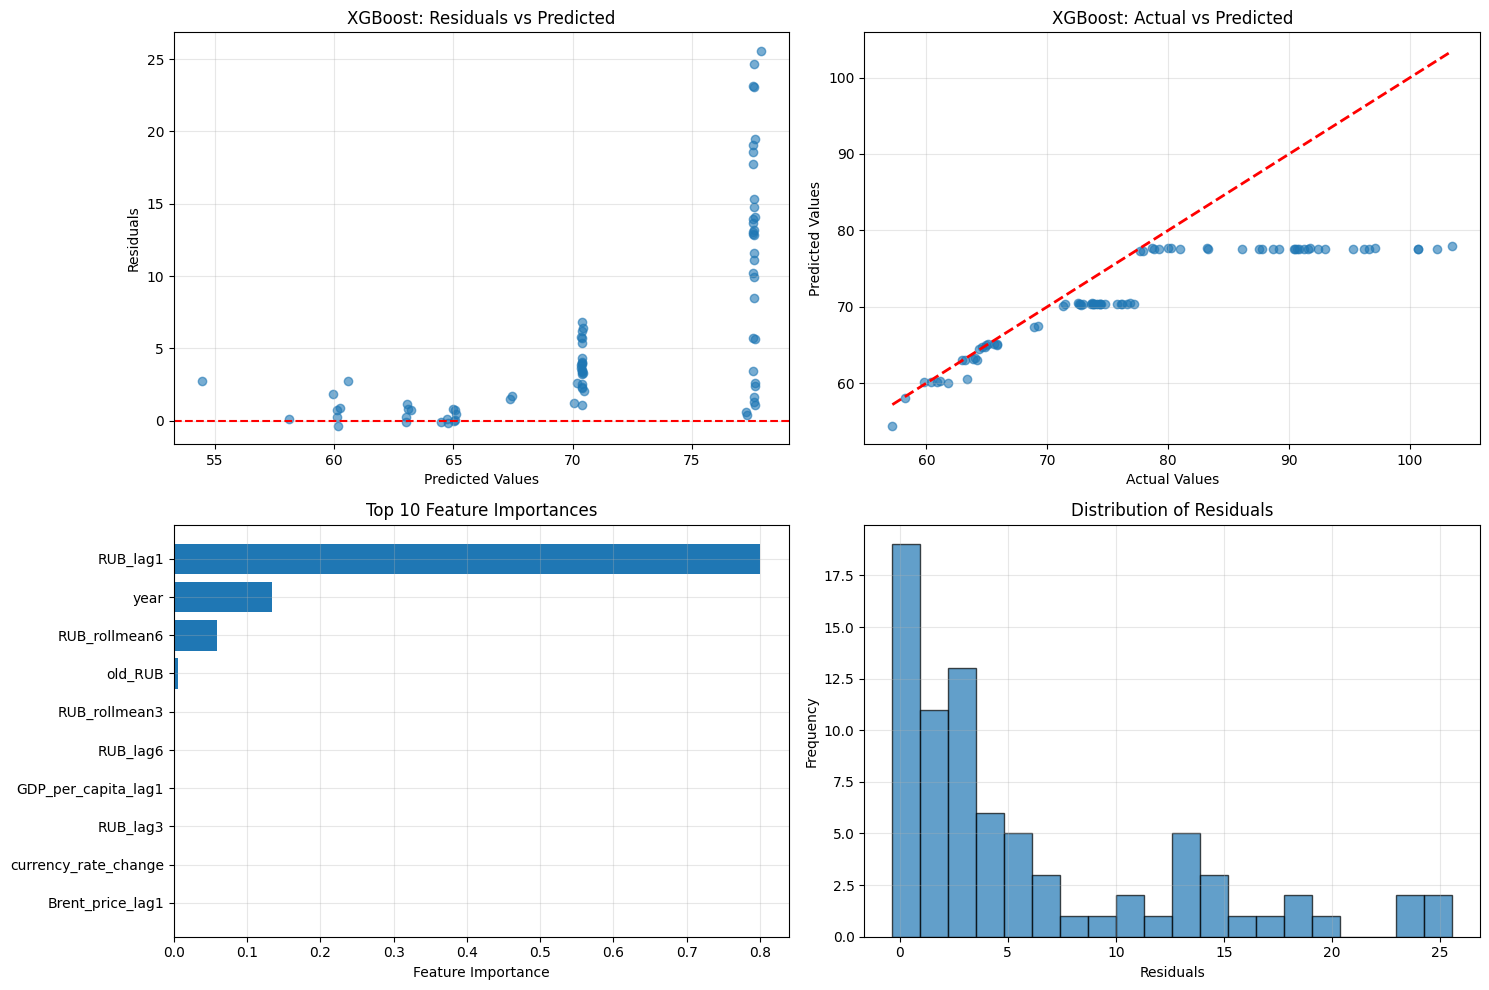


Detailed Performance Metrics:
RMSE: 9.0677
MAE: 6.0792
R²: 0.4191
Mean Absolute Percentage Error: 6.93%


In [ ]:
# (Removed) Additional diagnostics were here; reverting per user request.
pass


In [ ]:
# (Removed) Debugging cell; reverting per user request.
pass


=== DATA DEBUGGING ===
Data shape: (391, 32)
Target column (RUB) stats:
count    391.000000
mean      38.753744
std       25.745976
min        0.569000
25%       25.873829
50%       30.468626
75%       62.425452
max      103.470045
Name: RUB, dtype: float64

Target range: 0.57 to 103.47

Test set stats:
y_test range: 57.18 to 103.47
y_pred_xgb range: 54.44 to 77.91
y_pred_naive range: 57.18 to 103.47

Feature columns (30):
['old_RUB', 'year', 'month', 'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment', 'Inflation', 'currency_rate_change', 'sov_disrupt']

X_train_fixed shape: (312, 29)
X_test_fixed shape: (79, 29)

Any NaN values in X_test_fixed: 0
Any infinite values in X_test_fixed: 0
Any NaN values in y_test: 0
Any infinite values in y_test: 0


Using simplified features: ['RUB_lag1', 'RUB_lag3', 'RUB_lag6', 'GDP_per_capita', 'Inflation', 'Brent_price']

Simplified XGBoost RMSE: 16.0994
Improvement over baseline: -203.5%


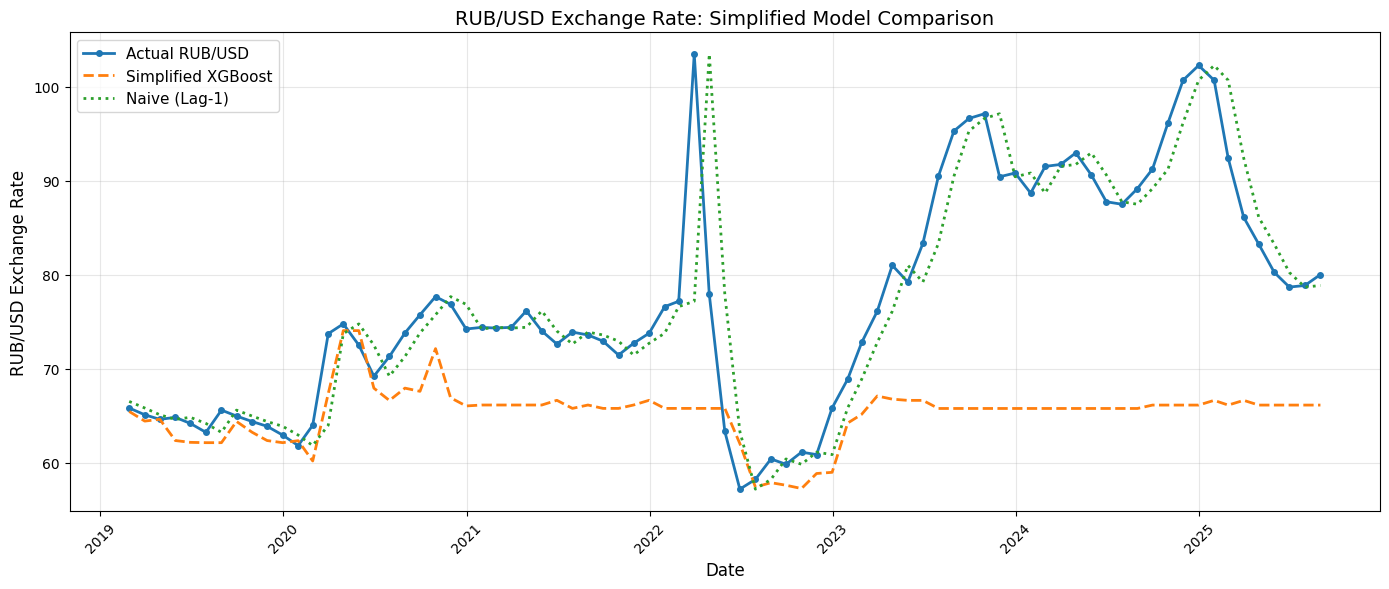

In [ ]:
# (Removed) Simplified model experiment; reverting per user request.
pass


Returns data shape: (384, 36)
Log returns stats:
count    384.000000
mean       0.011450
std        0.060440
min       -0.283867
25%       -0.010689
50%        0.004219
75%        0.020946
max        0.758009
Name: log_return, dtype: float64

Returns-based XGBoost RMSE: 31.2652
Improvement over baseline: -489.5%


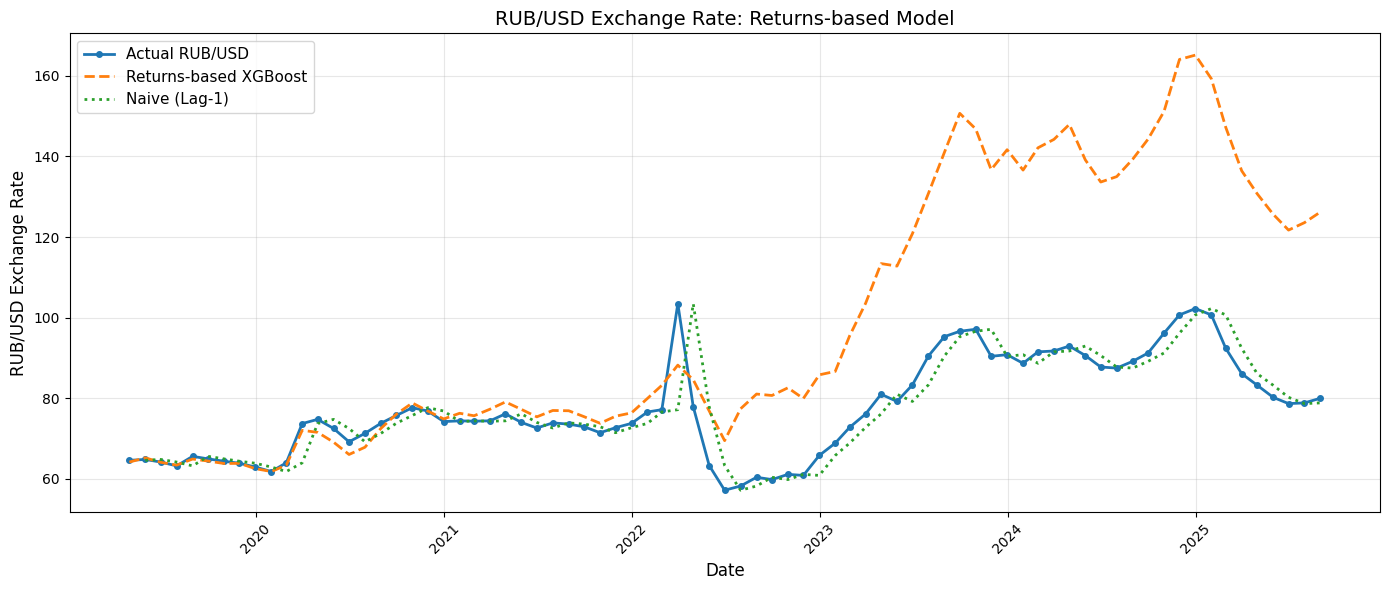

In [ ]:
# (Removed) Returns-based experiment; reverting per user request.
pass


In [ ]:
# (Removed) XGBoost Sep–Dec 2025 forecast; reverting per user request.
pass
